<a href="https://colab.research.google.com/github/salfaris/data-analysis/blob/master/regression_analysis_on_tfl_santander_cycles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Analysis on TfL Santander Cycles

Being in London for my undergrad, the TfL Santander Cycles (aka Boris Bikes) have always been my favourite mode of transport.

In this analysis, we will first do a deep dive exploration of the [Santander cycle dataset](https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset) obtained from Kaggle. This exploration includes cleaning the data, inspecting the trend of cycle hires, and looking for relationships between possible features and cycle hires.

We will then train a linear model on this dataset and apply feature engineering techniques such as:
1. Forward search model selection,
2. One-hot encoding,
3. Computing moving average,
4. Data normalisation using Yeo-Johnson transformation.

The idea is to build a model and a pipeline so that we can write an app (using Streamlit or Flask for example) to predict future cycle hires based on our chosen features.

Overall, I feel like this is an exciting project not only for me when I first did this out of curiosity, but also for you readers to learn how various statistical and machine learning techniques are applied to wrangle and model data.

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
# DATASET_DIR = '/work/datasets'
DATASET_DIR = '/content/gdrive/MyDrive/datasets'
PROJECT_DATASET_DIR = os.path.join(DATASET_DIR, 'santander-cycle-london-tfl')

if not os.path.exists(PROJECT_DATASET_DIR):
    os.makedirs(PROJECT_DATASET_DIR)

## Downloading data from Kaggle

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = DATASET_DIR
!kaggle datasets download hmavrodiev/london-bike-sharing-dataset
!unzip -o london-bike-sharing-dataset.zip -d {PROJECT_DATASET_DIR}
!rm london-bike-sharing-dataset.zip

  0% 0.00/165k [00:00<?, ?B/s]
100% 165k/165k [00:00<00:00, 11.3MB/s]
Archive:  london-bike-sharing-dataset.zip
  inflating: /content/gdrive/MyDrive/datasets/santander-cycle-london-tfl/london_merged.csv  


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.style.use("fivethirtyeight")

# Exploring the bicycle hiring dataset

In [5]:
data_path = os.path.join(PROJECT_DATASET_DIR, 'london_merged.csv')

hourly_df_raw = pd.read_csv(data_path)
hourly_df_raw.insert(1, "hires", hourly_df_raw.cnt)
hourly_df_raw.drop(["cnt"], axis=1, inplace=True)
hourly_df_raw.head()

,timestamp,hires,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


## Checking datatypes

The first thing I would always check is the data types of each columns. We could invoke the `.dtypes` attribute of the DataFrame, or we could use the `info()` method. I prefer the latter method as a first attack since it allows me to give a wider overview due to it including non-null counts as well as memory usage.


In [6]:
hourly_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   hires         17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


We see that `timestamp` is parsed as an `object` instead of datetime. Moreover, columns that we expect to be categorical – `weather_code`, `is_holiday`, `is_weekend` and `season` – are all parsed as `float64` instead of ints. These are fixed below.

In [7]:
hourly_df_raw['timestamp'] = pd.to_datetime(hourly_df_raw.timestamp)
hourly_df_raw.dtypes

timestamp       datetime64[ns]
hires                    int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [8]:
for col in ["weather_code", "is_holiday", "is_weekend", "season"]:
    hourly_df_raw[col] = hourly_df_raw[col].astype(int).astype("category")
hourly_df_raw.dtypes

timestamp       datetime64[ns]
hires                    int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code          category
is_holiday            category
is_weekend            category
season                category
dtype: object

## Checking null values

Naturally, the next thing to check is whether there are any **null values**. We have actually seen that there were no column with null values via the `.info()` method earlier. Here, we demonstrate this fact again using the `.isna().sum()` method chaining on the dataframe which counts the number of nulls in each column. As expected, we should get a column of zeros.

In [9]:
hourly_df_raw.isna().sum()

timestamp       0
hires           0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

## Inspection of the target variable – the number of cycle hires

A useful tool to do quantitative analysis in `pandas` is the `describe()` method. This gives us useful statistics such as mean, standard deviation and quartile ranges. We will now inspect the `hires` column.

In [10]:
hourly_df_raw.hires.describe()

count    17414.000000
mean      1143.101642
std       1085.108068
min          0.000000
25%        257.000000
50%        844.000000
75%       1671.750000
max       7860.000000
Name: hires, dtype: float64

While the `.describe()` method gives us actual numbers (and some intuitive sense to estimate outliers and the distribution), the faster way is to just look at a box plot of the data.

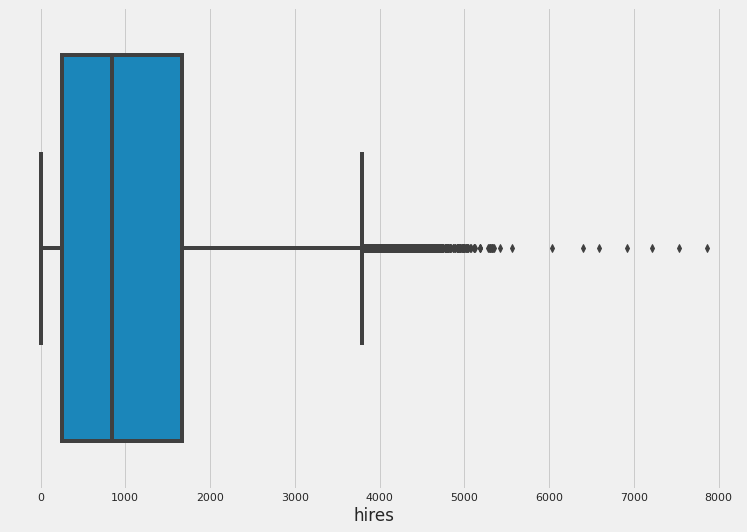

In [11]:
sns.boxplot(x=hourly_df_raw.hires);

From the box plot above, we further confirm that the data is left-skewed as expected from the `.describe()` method above – we saw that the 75th percentile lies at about 1670 hires whereas the maximal value is 7860 hires. Note, however, that there are several outliers, an issue that we might want to address.

## Is there any relationship between features and cycle hires?

The first question that is reasonable to ask is whether there is any linear relationship between features and cycle hires. One way to quickly do this is to plot the correlation matrix using a heatmap. In fact, it is enough to plot the lower triangular part of the matrix and no information is lost. We will do this using a trick we learnt [here](https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e).

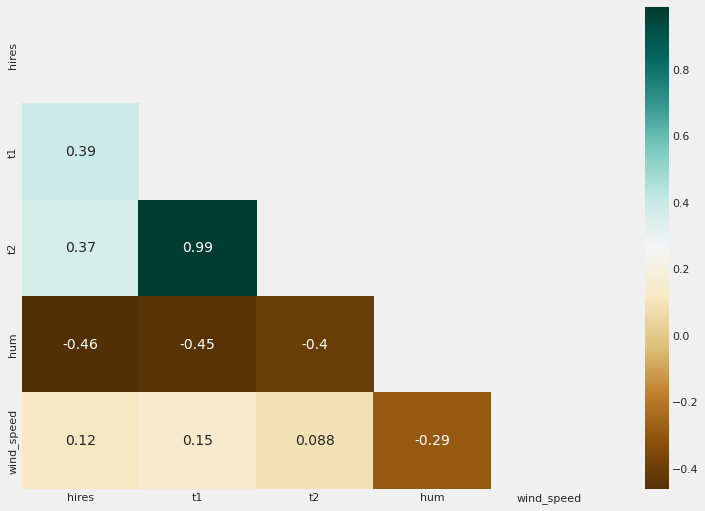

In [12]:
# Triangle heatmap: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
mask = np.triu(np.ones_like(hourly_df_raw.corr(), dtype=np.bool))
ax = sns.heatmap(hourly_df_raw.corr(), mask=mask, annot=True, cmap="BrBG")

### Short digression: Real temperature vs. *feels like* temperature

From the correlation matrix above, we see that the two temperatures `t1` (real temperature) and `t2` (*feels like* temperature) has the same power as far as linear relationship is concern. If they are indeed identical in terms of power, then we ought to remove one of them so that we can compute less and have a smaller linear model.

Our first line of attack is to invoke `.describe()` where we see that each statistic is almost identical!

In [13]:
hourly_df_raw[["t1", "t2"]].describe()

,t1,t2
count,17414.000000,17414.000000
mean,12.468091,11.520836
std,5.571818,6.615145
min,-1.500000,-6.000000
25%,8.000000,6.000000
50%,12.500000,12.500000
75%,16.000000,16.000000
max,34.000000,34.000000


Our second line of attack is plotting the two features against `hires` side by side.

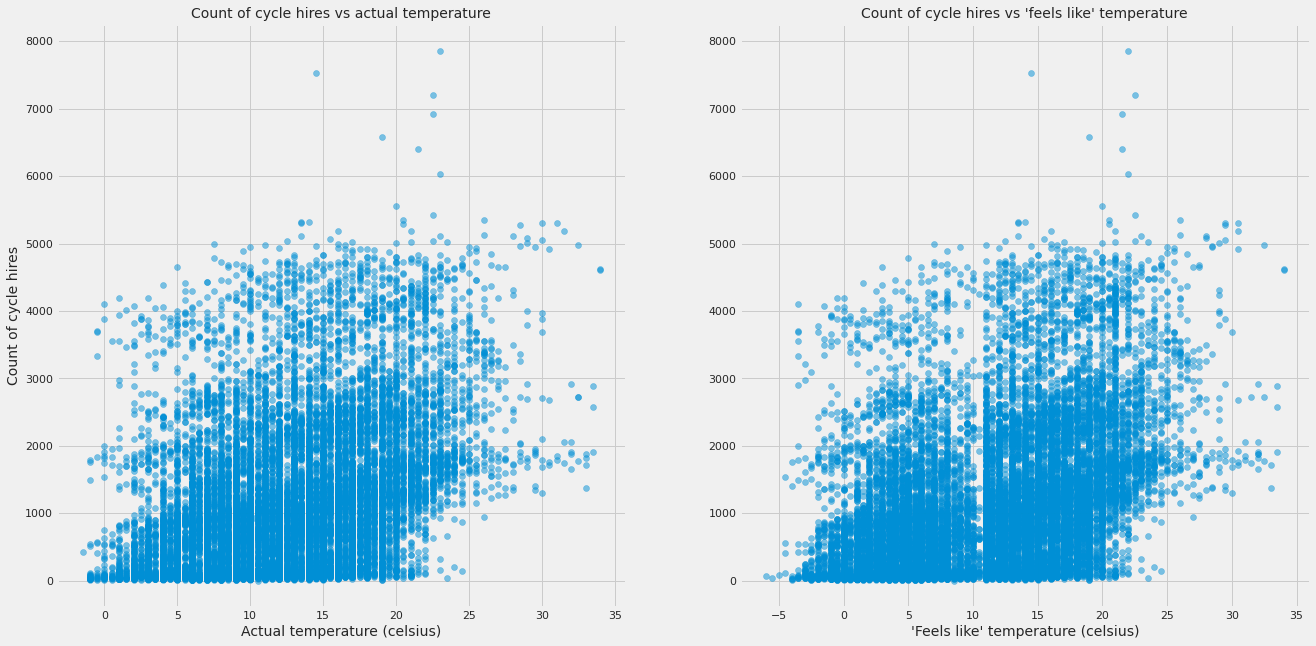

In [14]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].scatter(x=hourly_df_raw.t1, y=hourly_df_raw.hires, alpha=0.5)
ax[1].scatter(x=hourly_df_raw.t2, y=hourly_df_raw.hires, alpha=0.5)

fontsize = 14
ax[0].set_xlabel("Actual temperature (celsius)", fontsize=fontsize)
ax[0].set_title("Count of cycle hires vs actual temperature",
                fontsize=fontsize)

ax[1].set_title("Count of cycle hires vs 'feels like' temperature",
                fontsize=fontsize)
ax[1].set_xlabel("'Feels like' temperature (celsius)", fontsize=fontsize)

ax[0].set_ylabel("Count of cycle hires", fontsize=fontsize)
plt.show()

The plots confirms our suspicions as we see that even the distribution of data is identical! I decided to drop `t2` and rename `t1` to `temp`. The drop of `t2` over `t1` is just an arbitrary choice. 

In [15]:
hourly_df_raw.insert(2, "temp", hourly_df_raw.t1)
hourly_df_raw.drop(["t1", "t2"], axis=1, inplace=True)
hourly_df_raw.head()

,timestamp,hires,temp,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,93.0,6.0,3,0,1,3
1,2015-01-04 01:00:00,138,3.0,93.0,5.0,1,0,1,3
2,2015-01-04 02:00:00,134,2.5,96.5,0.0,1,0,1,3
3,2015-01-04 03:00:00,72,2.0,100.0,0.0,1,0,1,3
4,2015-01-04 04:00:00,47,2.0,93.0,6.5,1,0,1,3


### Quantitative features vs. cycle hires

For ease of use, we define a function `scatterplot_feat_vs_hires` so that we don't have to copy and paste the plotting code again and again.

In [16]:
def scatterplot_feat_vs_hires(df: pd.DataFrame, feat_name: str, feat_label: str = None):
    if feat_label is None:
        feat_label = feat_name
    if feat_name not in df.columns:
        raise KeyError(f"'{feat_name}' is not a column in the dataframe.")

    _, ax = plt.subplots(figsize=(10, 5))
    sns.regplot(x=feat_name, y="hires", data=df, ci=95, 
                scatter_kws={"alpha": 0.2}, line_kws={"color": "red", "lw": 2, "alpha": 0.8})

    fontsize = 14
    ax.set_xlabel(feat_label, fontsize=fontsize)
    ax.set_ylabel("Count of cycle hires", fontsize=fontsize)
    ax.set_title(f"Count of cycle hires vs {feat_label}", fontsize=fontsize)
    plt.show()

We plot again the count of cycle hires against temperature `temp`. This time, we observe more closely that there exists a linear relationship – as the temperature increases, the number of cycle hires increases. This should be expected as people tend to cycle in warmer weather.

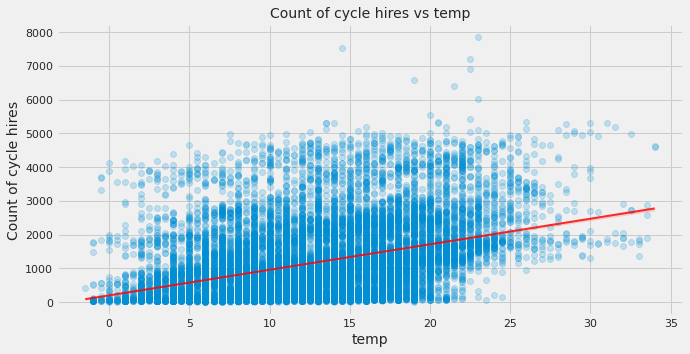

In [17]:
scatterplot_feat_vs_hires(hourly_df_raw, "temp")

The plot of number of cycle hires against humidity (`hum`) shows that that there is a significant inverse linear relationship between the two. The more humid, the less cycle hires which is also quite expected in some sense.

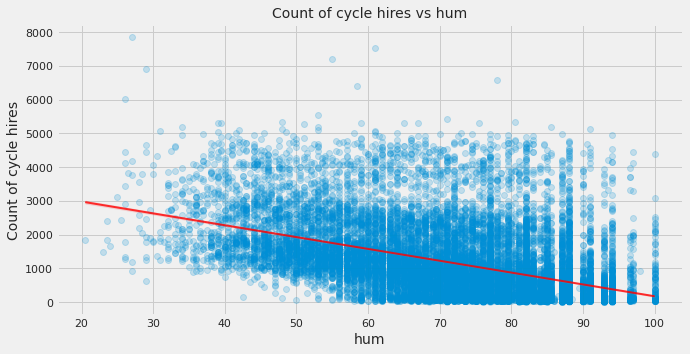

In [18]:
scatterplot_feat_vs_hires(hourly_df_raw, "hum")

The final feature `wind_speed` is a bit tricky. Firstly, we must acknowledge that the average wind speed of our dataset lies at about 16 km/h. This is evident as we  invoke the `.describe()` method and by looking the histogram of the feature.

In [19]:
hourly_df_raw.wind_speed.describe()

count    17414.000000
mean        15.913063
std          7.894570
min          0.000000
25%         10.000000
50%         15.000000
75%         20.500000
max         56.500000
Name: wind_speed, dtype: float64

Text(0.5, 1.0, 'Distribution of wind speed')

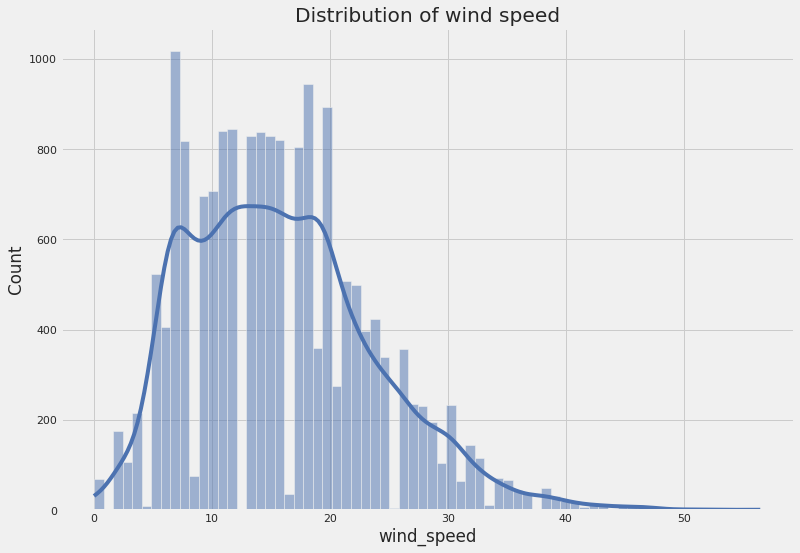

In [20]:
ax = sns.histplot(hourly_df_raw.wind_speed, kde=True)
ax.set_title("Distribution of wind speed")

Or if you want concrete numbers based on 5 bins.

In [21]:
hourly_df_raw.wind_speed.value_counts(bins=5, sort=False)

(-0.0575, 11.3]    5659
(11.3, 22.6]       8483
(22.6, 33.9]       2853
(33.9, 45.2]        386
(45.2, 56.5]         33
Name: wind_speed, dtype: int64

The reason of our discussion regarding the distribution of wind speed will become apparent now. By doing a regression plot of the cycle hires against `wind_speed` (see cell below), we see that a line with positive slope is fitted although the data is clearly inverse in relation. This is because there is not enough data with `wind_speed` > 30.

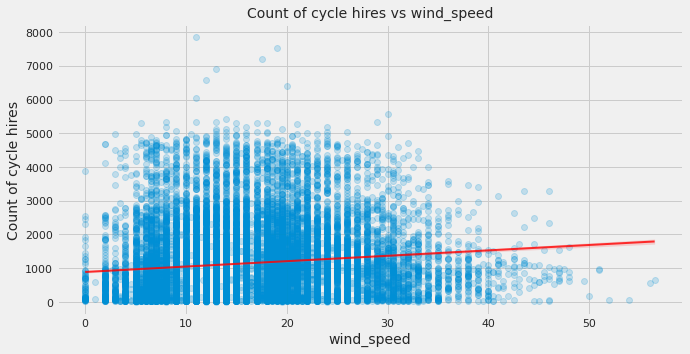

In [22]:
scatterplot_feat_vs_hires(hourly_df_raw, "wind_speed")

If we sample this correctly (i.e. so that the wind speed is now balanced in the resulting sampling), we should expect a line with negative slope to be fitted instead as seen below.

In [23]:
def get_n_sample_of_windspeed_interval(n: int, lo: float, hi: float):
    df_filtered_on_interval = hourly_df_raw[((hourly_df_raw.wind_speed >= lo) 
                                & (hourly_df_raw.wind_speed < hi))]
    # Sampling with replacement.                            
    n_samples = df_filtered_on_interval.sample(n=n, random_state=44, replace=True)
    return n_samples[["wind_speed", "hires"]]

n = 100  # Large n is ok since we are sampling with replacement.
samples = [get_n_sample_of_windspeed_interval(n, i, i+10) 
                for i in range(0, 60, 10)]
balanced_windspeed_df = pd.concat(samples)

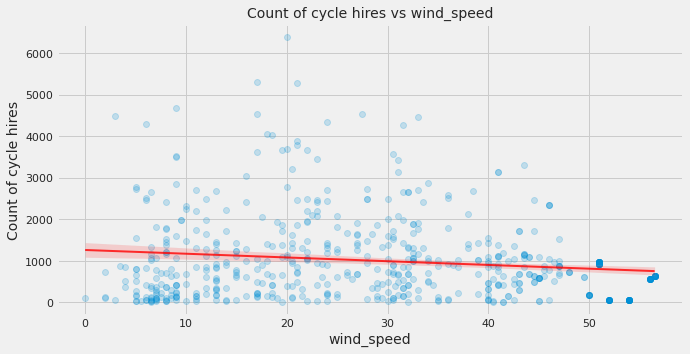

In [24]:
scatterplot_feat_vs_hires(balanced_windspeed_df, "wind_speed")

### Categorical features vs. cycle hires

The relationship between categorical features and cycle hires are easily captured using a bar plot.

In [25]:
season_mapping = {
    0: "spring",
    1: "summer",
    2: "fall",
    3: "winter",
}

weather_code_mapping = {
    1: "clear",
    2: "scattered clouds",
    3: "broken clouds",
    4: "cloudy",
    7: "rain",
    10: "rain with thunderstorm",
    26: "snowfall",
    94: "freezing fog",
}

hourly_df_raw["weather_code_str"] = hourly_df_raw.weather_code.map(weather_code_mapping)
hourly_df_raw["season_str"] = hourly_df_raw.season.map(season_mapping)

We plot the count of cycle hires by weather. It is not surprising that users tend to cycle on days when the sky is clear or clear-ish (broken and scattered clouds fits this description) and tend to avoid when it is cloudy, raining or heck a snowfall.

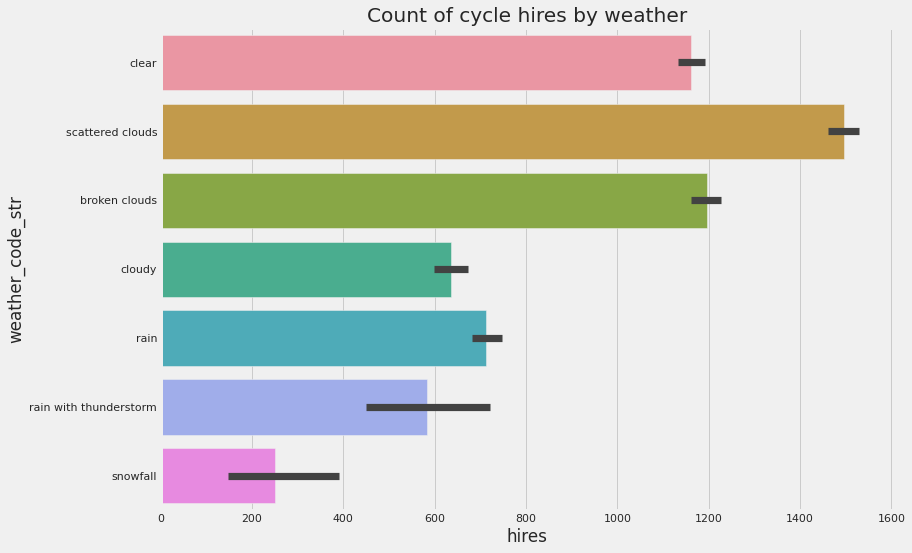

In [26]:
ax = sns.barplot(data=hourly_df_raw, x="hires", y="weather_code_str")
ax.set_title("Count of cycle hires by weather");

What's surprising (at least for me) is that the number of cycle hires is a third higher on working days compared to holidays. This implies that the cycles are primarily used for people going to work instead of for leisure. How about if we group the holidays by season?

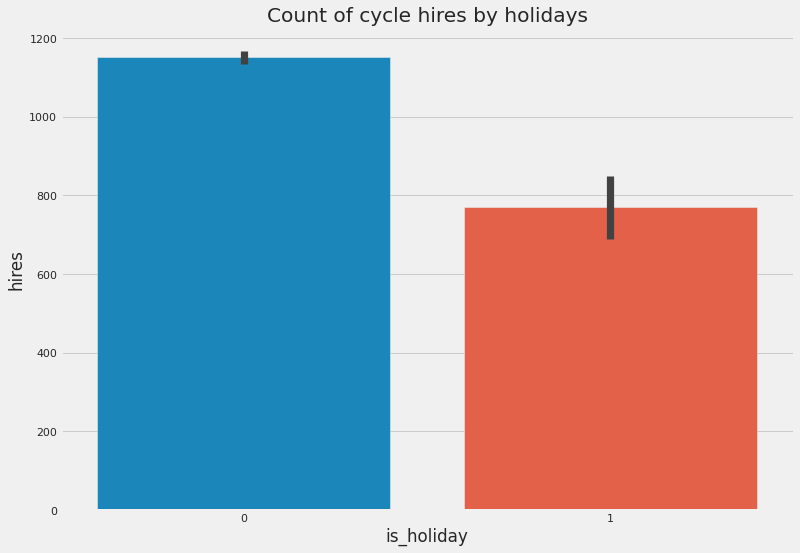

In [27]:
ax = sns.barplot(data=hourly_df_raw, x="is_holiday", y="hires")
ax.set_title("Count of cycle hires by holidays");

It seems that on non-holidays, more users tend to hire in the summer whereas during holidays, spring and summer has about equal number of hires (although the confidence intervals are questionable).

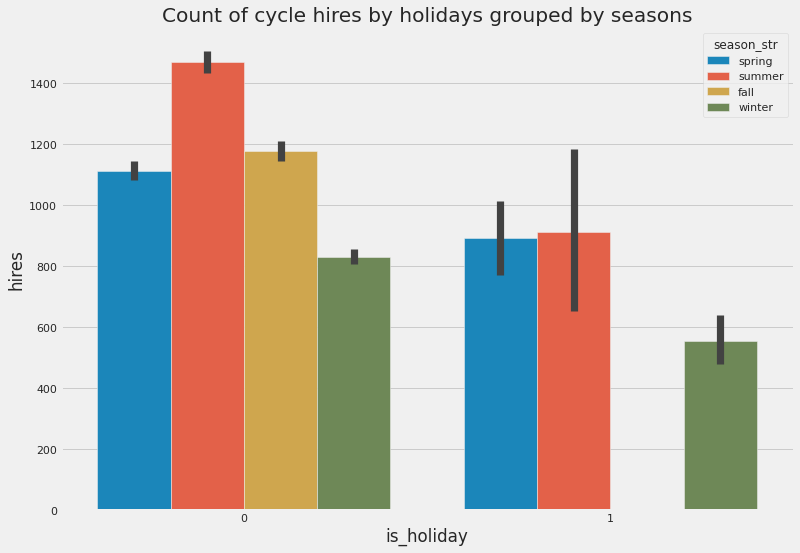

In [28]:
ax = sns.barplot(data=hourly_df_raw, x="is_holiday", y="hires", hue="season_str")
ax.set_title("Count of cycle hires by holidays grouped by seasons");

Unsurprisingly by now, the number of cycle hires is much higher on weekdays, although it is about only a fifth higher.

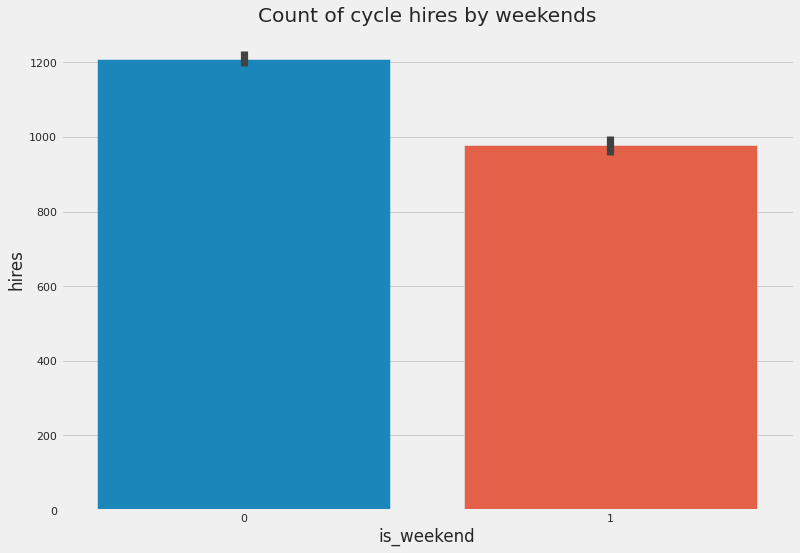

In [29]:
ax = sns.barplot(data=hourly_df_raw, x="is_weekend", y="hires")
ax.set_title("Count of cycle hires by weekends");

And if we group by seasons, the same distribution comes up.

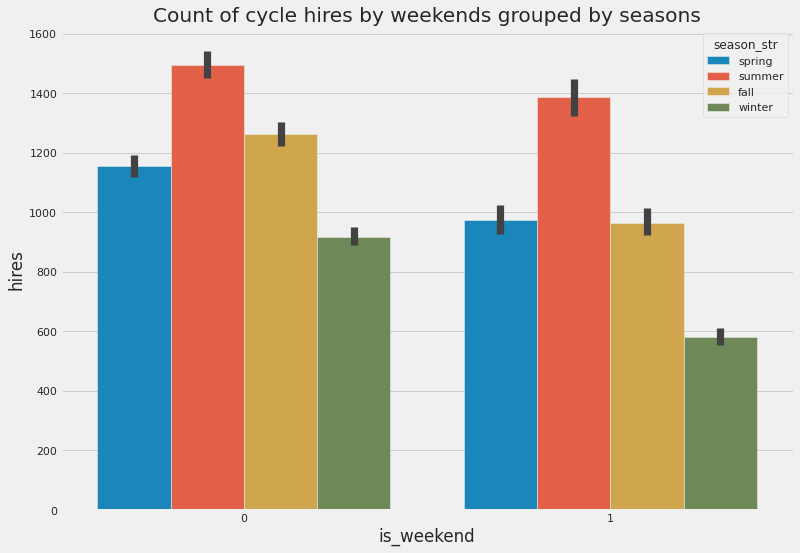

In [30]:
ax = sns.barplot(data=hourly_df_raw, x="is_weekend", y="hires", hue="season_str")
ax.set_title("Count of cycle hires by weekends grouped by seasons");

In [31]:
hourly_df_raw.drop(["season_str", "weather_code_str"], axis=1, inplace=True)
hourly_df_raw.head()

,timestamp,hires,temp,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,93.0,6.0,3,0,1,3
1,2015-01-04 01:00:00,138,3.0,93.0,5.0,1,0,1,3
2,2015-01-04 02:00:00,134,2.5,96.5,0.0,1,0,1,3
3,2015-01-04 03:00:00,72,2.0,100.0,0.0,1,0,1,3
4,2015-01-04 04:00:00,47,2.0,93.0,6.5,1,0,1,3


How about if we look at cycle hires by hour, what do you think the distribution would be? We have seen from the bar plots on cycle hires against `is_weekend` and `is_holiday` that users use Santander cycles mostly for work. So you would expect that the distribution of cycle hires by hour would be high about 8 a.m. (going to work) and 6 p.m. (going home from work); and you're not wrong!

In [32]:
hourly_df_raw.insert(1, "hour", hourly_df_raw.timestamp.dt.hour)
hourly_df_raw.head()

,timestamp,hour,hires,temp,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,0,182,3.0,93.0,6.0,3,0,1,3
1,2015-01-04 01:00:00,1,138,3.0,93.0,5.0,1,0,1,3
2,2015-01-04 02:00:00,2,134,2.5,96.5,0.0,1,0,1,3
3,2015-01-04 03:00:00,3,72,2.0,100.0,0.0,1,0,1,3
4,2015-01-04 04:00:00,4,47,2.0,93.0,6.5,1,0,1,3


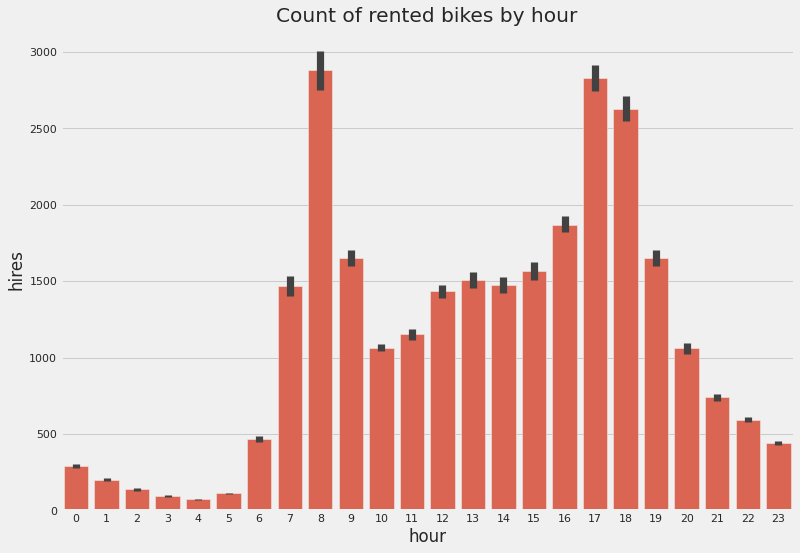

In [33]:
ax = sns.barplot(data=hourly_df_raw, x="hour", y="hires", color="#ef553b")
ax.set_title("Count of rented bikes by hour");

The number of cycle hires at 8 a.m. and the number of cycle hires at about 5 and 6 p.m. matches (modulo the confidence interval). So one can infer that users who go to work using a Santander cycle also go back home using a Santander cycle. One can make a guess that these people are probably on a yearly subscription.

One interesting observation is that the number of cycle hires decreases exponentially from 6 p.m. to 4 a.m. which suggests a one-way flow so to speak – that is, people hire cycles to go (most likely to their) home instead of going somewhere else. Another way to think about this hypothesis is that there are twice as many people using the cycles to go home in contrast to people using it to go elsewhere (and then returning home).

# Modelling the data

Now that we have understood our data, we can start training a model on it. We follow the so-called Occam's razor principle which suggest to choose the simplest model where possible. The natural starting point is thus linear regression $\boldsymbol{y} = X \boldsymbol{\beta} + \boldsymbol\varepsilon$ which can be considered the simplest machine learning model.

We will first separate our data into `target` and `features`.

In [34]:
target = hourly_df_raw["hires"]
features = hourly_df_raw.drop(["hires", "timestamp"], axis=1)
features.head()

,hour,temp,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,0,3.0,93.0,6.0,3,0,1,3
1,1,3.0,93.0,5.0,1,0,1,3
2,2,2.5,96.5,0.0,1,0,1,3
3,3,2.0,100.0,0.0,1,0,1,3
4,4,2.0,93.0,6.5,1,0,1,3


We will use `statsmodels` to work with linear models since it provides ready-to-use statistical tools such as computing studentized residuals (we shall see this later on). On the other hand, we will use `scikit-learn` and `scipy` for data preprocessing and feature engineering.

In [35]:
!pip install -U scikit-learn

In [36]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Naturally, we will split the dataset into train and test sets.

> The test set here is actually a *dev (development) set*. That is, we will try to make our model fit to it. Note its difference with an actual test set which would usually be evaluated when the model has been tuned without being fitted to it!

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=44)

## Benchmark model

We will always add the bias (i.e. intercept) term by using `sm.add_constant()` to get a better fit of the data.

In [38]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train).fit()

y_pred = model_sm.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE naive linear regression: {rmse}")
print(f"R^2 score: {r2}")

RMSE naive linear regression: 935.4935355414923
R^2 score: 0.27124090896804687


In [39]:
target.describe()

count    17414.000000
mean      1143.101642
std       1085.108068
min          0.000000
25%        257.000000
50%        844.000000
75%       1671.750000
max       7860.000000
Name: hires, dtype: float64

We use two metrics to evaluate our model: **root mean squared error (RMSE)** which measures how far does our prediction deviates from its original value; and **$R^2$ score** which measures how much of the original points actually lie on the regression line.

Here, we have an RMSE of **935.49** which is bad but not horrible considering our range of hires is between 0 and 7860. Our $R^2$ score is **0.271** which is quite poor. It is roughly saying that only 27% of all the (variation in) hires can be explained by our model based on the given features. We shall use these two values as our benchmark when trying to improve the model.

> Warning: It is dangerous to use $R^2$ score alone when improving models and this can be convinced by looking at examples which we shall not cover here.

## Feature engineering

### Model selection using forward search

When the number of features (i.e. predictors) is small, we can do what's called the *all subset regression* where we compute all possible linear models (without interactions) and compare them. For example, if we have two features $x_1$ and $x_2$, then we compute and compare the models

$$y^{(i)} = \beta_0, \quad y^{(i)} = \beta_0 + \beta_1 x_{1}^{(i)}, \quad y^{(i)} = \beta_0 + \beta_2 x_{2}^{(i)}, \quad y^{(i)} = \beta_0 + \beta_1 x_{1}^{(i)} + \beta_2 x_{2}^{(i)}.$$

> *Convention: we write $y^{(i)}$ (resp. $x^{(i)})$ to mean the $i$-th target (resp. example/feature vector). If further we write $x^{(i)}_{p}$, then this means the $p$-th feature of the $i$-th example.*

In general, one can expect to have $2^p$ models when having $p$ features. For us, we would have to compare $2^8 = 256$ linear models which is computationally expensive!

One alternative method is to use *forward search* where we start with the simplest model and add power (and interaction) terms. So for example, if we have two features $x_1$ and $x_2$ as before, our first search yields the single model $y^{(i)} = \beta_0$; and our second search would compute and compare the models

$$y^{(i)} = \beta_0, \quad y^{(i)} = \beta_0 + \beta_1 x_{1}^{(i)} + \beta_2 x_{2}^{(i)}, $$

$$\quad y^{(i)} = \beta_{00} + \beta_{01} x_{1}^{(i)} + \beta_{11} (x_{1}^{(i)})^2 + \beta_{02} x_{2}^{(i)} + \beta_{22} (x_{2}^{(i)})^2 + \beta_{12} x_{1}^{(i)}x_{2}^{(i)}.$$

A good rule to follow when doing forward search is to preserve *functional marginality*. That is,

1. Always preserve the bias (i.e. intercept) term in the model.
2. If $x_p^{\lambda}$ is present in the model, then $x_p^{\ell}$ must be in the model for any $1 < \ell < \lambda$ (the powers here are applied elementwise to the vector $x_p$).
3. Both $x_p$ and $x_q$ must be in the model if the interaction term $x_p x_q$ is in the model.

Thankfully, we can do forward search that preserves functional marginality easily by using `PolynomialFeatures` provided by the `scikit-learn` API.

In [40]:
from sklearn.preprocessing import PolynomialFeatures

In [41]:
rmses = []
r2_scores = []
degrees = [1, 2, 3, 4]
for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_train_tmp = poly.fit_transform(X_train)
    X_test_tmp = poly.transform(X_test)

    # No need to do sm.add_constant() as that is
    # already done by PolynomialFeatures.
    model_sm = sm.OLS(y_train, X_train_tmp).fit()
    y_pred = model_sm.predict(X_test_tmp)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    rmses.append(rmse)
    r2_scores.append(r2)

In [42]:
for d, rmse, r2 in zip(degrees, rmses, r2_scores):
    print(f"Degree {d} | RMSE: {rmse}, r^2: {r2}")

Degree 1 | RMSE: 901.4078897812993, r^2: 0.323379558881113
Degree 2 | RMSE: 793.7306427805116, r^2: 0.47537534340213294
Degree 3 | RMSE: 746.7781568841938, r^2: 0.5356070513403381
Degree 4 | RMSE: 1041.3318637736706, r^2: 0.09701461938827138


Text(0, 0.5, 'Root mean squared error (RMSE)')

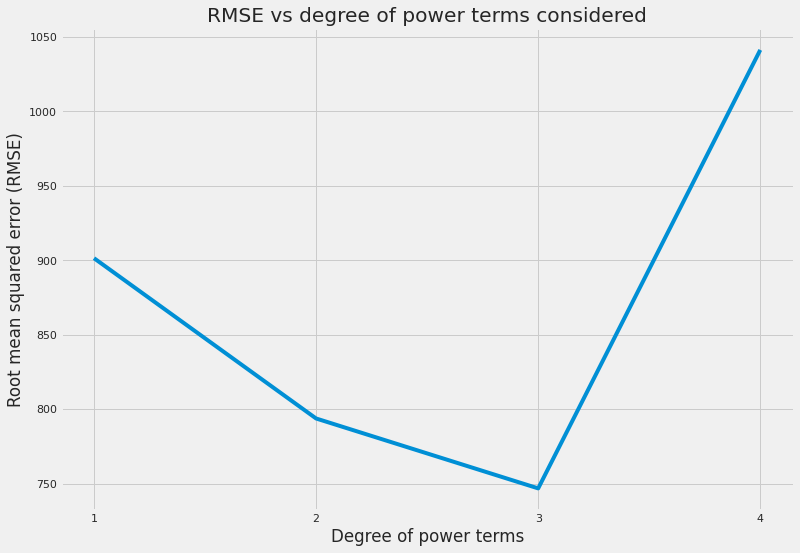

In [43]:
ax = sns.lineplot(x=degrees, y=rmses)
ax.set(xticks=degrees)
ax.set_title("RMSE vs degree of power terms considered")
ax.set_xlabel("Degree of power terms")
ax.set_ylabel("Root mean squared error (RMSE)")

Text(0, 0.5, '$R^2$ scores')

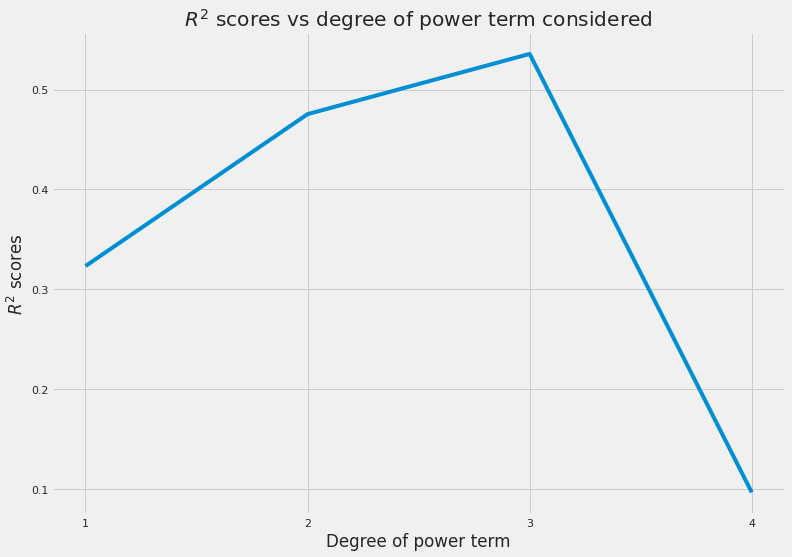

In [44]:
ax = sns.lineplot(x=degrees, y=r2_scores)
ax.set(xticks=degrees)
ax.set_title("$R^2$ scores vs degree of power term considered")
ax.set_xlabel("Degree of power term")
ax.set_ylabel("$R^2$ scores")

From our line plots above, it becomes obvious that the model with power terms of degree 3 (cubic power term) minimizes the RMSE at **746.77** hires and maximizes the $R^2$ score at **0.536**. 

The RMSE decreased by approximately 20% from our benchmark RMSE of 935.49 while the $R^2$ score approximately doubles from the benchmark $R^2$ score of 0.271. In other words, the $R^2$ score improves by about 100%!

### One-hot encoding on categorical data

Previously, our model has been learning the categorical columns by viewing it as a real number. This sometimes work out to be okay (e.g. if the category is binary). However, to truly get the expressive power of categorical columns, we need to treat these categorical values using dummy variables. One method to do this is what's called *one-hot encoding* which basically creates a new binary column for each possible category for each categorical columns. To use one-hot encoding, we can use `scikit-learn`'s built-in `OneHotEncoder`.

In [45]:
from sklearn.preprocessing import OneHotEncoder

In [46]:
categorical_cols = X_train.columns[X_train.dtypes == "category"].tolist()

enc = OneHotEncoder(handle_unknown="error", sparse=False)
enc_X_train = enc.fit_transform(X_train[categorical_cols])

# Encoded X_train above is a numpy array. To convert it back to a DataFrame,
# we use pd.DataFrame with the transformed columns and original X_train index.
# The index is important when concatenating to the original X_train dataframe
# containing the non-categorical columns as the join is on index.
enc_X_train = pd.DataFrame(enc_X_train,
                           columns=enc.get_feature_names_out(categorical_cols),
                           index=X_train.index)
enc_X_train = pd.concat([X_train, enc_X_train], axis=1)\
                .drop(categorical_cols, axis=1)
enc_X_train.head()

,hour,temp,hum,wind_speed,weather_code_1,weather_code_2,weather_code_3,weather_code_4,weather_code_7,weather_code_10,weather_code_26,is_holiday_0,is_holiday_1,is_weekend_0,is_weekend_1,season_0,season_1,season_2,season_3
12423,12,22.5,63.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
12409,22,14.0,82.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9684,16,5.0,81.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
13946,18,19.0,46.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6723,4,9.5,79.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Once we have a one-hot encoder, we would want to transform the test set as well as future new samples that we want to predict. For this, we introduce the following function.

In [47]:
def preprocess_new_sample(new_sample, ohe_encoder):
    for col in ["weather_code", "is_holiday", "is_weekend", "season"]:
        new_sample[col] = new_sample[col].astype(int).astype("category")

    categorical_cols = new_sample.columns[new_sample.dtypes 
                                            == "category"].tolist()
    enc_new_sample = ohe_encoder.transform(new_sample[categorical_cols])

    index = new_sample.index
    enc_new_sample = pd.DataFrame(enc_new_sample,
                                columns=ohe_encoder.get_feature_names_out(
                                            categorical_cols),
                                index=index)
    enc_df = pd.concat([new_sample, enc_new_sample], axis=1)\
                .drop(categorical_cols, axis=1)
    return enc_df

In [48]:
test_sample = pd.DataFrame(
    dict(hour=13, 
         temp=15, 
         hum=21, 
         wind_speed=17.1, 
         weather_code=3, 
         is_holiday=0, 
         is_weekend=0, 
         season=3), 
    index=[0]
)
preprocess_new_sample(test_sample, enc)

,hour,temp,hum,wind_speed,weather_code_1,weather_code_2,weather_code_3,weather_code_4,weather_code_7,weather_code_10,weather_code_26,is_holiday_0,is_holiday_1,is_weekend_0,is_weekend_1,season_0,season_1,season_2,season_3
0,13,15,21,17.1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [49]:
enc_X_test = preprocess_new_sample(X_test, enc)
enc_X_test.head()

,hour,temp,hum,wind_speed,weather_code_1,weather_code_2,weather_code_3,weather_code_4,weather_code_7,weather_code_10,weather_code_26,is_holiday_0,is_holiday_1,is_weekend_0,is_weekend_1,season_0,season_1,season_2,season_3
2631,23,8.0,82.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
16437,7,10.0,82.0,19.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4886,5,16.0,83.0,27.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
846,7,4.0,81.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3406,6,12.0,72.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [50]:
enc_X_train_sm = sm.add_constant(enc_X_train)
enc_X_test_sm = sm.add_constant(enc_X_test)

model_sm = sm.OLS(y_train, enc_X_train_sm).fit()

y_pred = model_sm.predict(enc_X_test_sm)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"RMSE linear regression on one hot encoded data: {rmse}")
print(f"R^2 score: {r2}")

RMSE linear regression on one hot encoded data: 891.1841970386661
R^2 score: 0.3386408637384123


In the one-hot encoded linear model, there's only a 5% improvement in the RMSE compared to the benchmark RMSE, going from **891.18** to 935.49. But there is about a 25% increase in the $R^2$ score from the benchmark value of 0.271 to **0.339**. However, both of these scores are worse compared to the cubic power term model. Let's try a cubic power term model for the one-hot encoded dataset.

In [51]:
poly = PolynomialFeatures(degree=3)
enc_X_train_tmp = poly.fit_transform(enc_X_train)
enc_X_test_tmp = poly.transform(enc_X_test)

# No need to do sm.add_constant() as that is
# already done by PolynomialFeatures.
model_sm = sm.OLS(y_train, enc_X_train_tmp).fit()
y_pred = model_sm.predict(enc_X_test_tmp)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print("RMSE linear regression on one-hot encoded + cubic power term data:" 
        + f" {rmse}")
print(f"R^2 score: {r2}")

RMSE linear regression on one-hot encoded + cubic power term data: 738.4896152711983
R^2 score: 0.5458585010096415


There is only a small difference in the RMSE and $R^2$ score of this model compared to its non-one-hot encoded counterpart. Considering how computationally expensive this model were, we would be better of just using the original cubic power term linear model.

In [52]:
poly = PolynomialFeatures(degree=3)
X_train_deg3 = poly.fit_transform(X_train)
X_test_deg3 = poly.transform(X_test)

# No need to do sm.add_constant() as that is
# already done by PolynomialFeatures.
model_sm = sm.OLS(y_train, X_train_deg3).fit()
y_pred = model_sm.predict(X_test_deg3)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print("RMSE linear regression on cubic power term transformation:" 
        + f" {rmse}")
print(f"R^2 score: {r2}")

RMSE linear regression on cubic power term transformation: 746.7781568841938
R^2 score: 0.5356070513403381


Since the number of features is getting large (hence, the number of estimators), perhaps the adjusted $R^2$ score is a better metric.

In [53]:
def adjusted_r2_score(r2, n, p):
    return 1 - (1-r2) * ((n-1.)/(n-p-1.))

adjusted_r2 = adjusted_r2_score(r2, len(y_test), X_test_deg3.shape[1])
print(f"Adjusted R^2 score: {adjusted_r2}")

Adjusted R^2 score: 0.5204608096860894


### Moving average (MA) as a feature

Since our data is indexed by time, one powerful feature engineering approach we can use is that of *moving average*.

The idea is to compute the mean of the cycle hires over a certain *lag* period, and use this computed mean value as a feature. For example, consider the following data

| Hour | Hires |
| --- | ----------- |
| 0 | 5 |
| 1 | 3 |
| 2 | 7 |
| 3 | 1 |
| 4 | 21 |
| 5 | 57 |
| 6 | ?? |

The moving average with lag $\lambda$ (often called MA $\lambda$) at hour 6 for $\lambda = 2, 3, 4$ is given by

|$\lambda$ |MA $\lambda$|
|---|---|
|2|(57 + 21)/2 = 39|
|3|(57 + 21 + 1)/3 = 26.3|
|4|(57 + 21 + 1 + 7)/4 = 21.5|

To apply moving averages in pandas, one can simply chain the `.rolling()` method followed by `.mean()` to compute the mean. For simplicity, we shall apply the moving average to the original dataset instead of the training set.



In [54]:
hourly_df_lag = hourly_df_raw.copy()

ma_lags = [2, 5, 10]
for i in ma_lags:
    hourly_df_lag["hires_ma_" + str(i)] = hourly_df_lag.hires.rolling(i).mean()

hourly_df_lag.dropna(inplace=True)

In [55]:
target = hourly_df_lag.hires
features = hourly_df_lag.drop(["hires", "timestamp"], axis=1)

X_train_lag, X_test_lag, y_train_lag, y_test_lag = train_test_split(
    features, target, test_size=0.3, random_state=44)

In [56]:
X_train_lag_sm = sm.add_constant(X_train_lag)
X_test_lag_sm = sm.add_constant(X_test_lag)

model_lag_sm = sm.OLS(y_train_lag, X_train_lag_sm).fit()
y_pred = model_lag_sm.predict(X_test_lag_sm)

rmse = mean_squared_error(y_test_lag, y_pred, squared=False)
r2 = r2_score(y_test_lag, y_pred)
print(f"RMSE linear regression on data with lag: {rmse}")
print(f"R^2 score: {r2}")

RMSE linear regression on data with lag: 320.7628793136828
R^2 score: 0.9134505805880055


This is the most amazing performance we have so far! The RMSE on this dataset is a 65.7% decrease from our benchmark RMSE of 935.49 to **320.76**. Moreover, the $R^2$ score improved by 237% from 0.271 to **0.913**!

Let's look at the heatmap again.

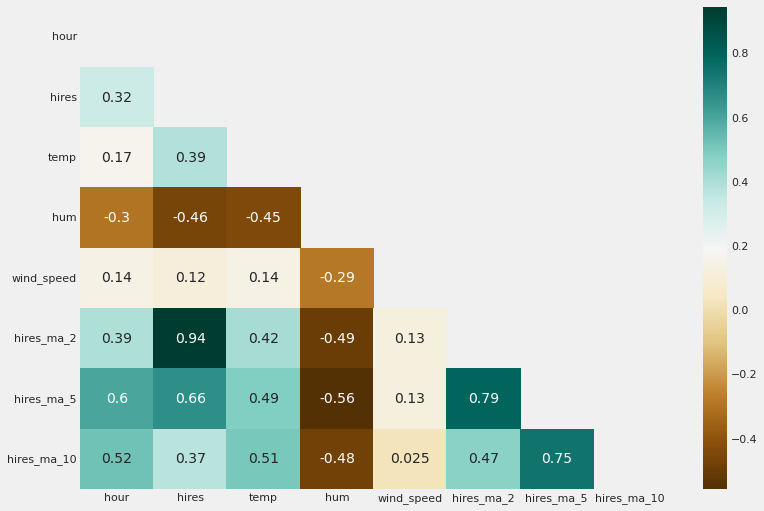

In [57]:
mask = np.triu(np.ones_like(hourly_df_lag.corr(), dtype=np.bool))
ax = sns.heatmap(hourly_df_lag.corr(), mask=mask, annot=True, cmap="BrBG")

As expected from the performance we have recently, the correlations between hires and its lagged versions are strong.

There is a catch, however. Since the end goal of this project is to create an app to predict cycle hires based on temperature, wind speed and so on, using moving average as a feature would require the user to know it beforehand – not really realistic if you ask me. 

One obvious way to tackle this problem is to have a database containing the hires of the previous hours from which we can calculate the moving average. However, we will assume that we don't have the resources to do that and not use this feature.

## Looking at diagnostic plots

Recall that our best model so far is trained on the cubic power term transformed data (defined in `X_train_deg3` and `X_test_deg3`). We now look at two plots usually used to gauge the performance of linear models:

1. Residuals vs Fitted plot
2. Normal probability plot (aka normal Q-Q plot, or just Q-Q plot)

In [58]:
model_sm = sm.OLS(y_train, X_train_deg3).fit()
y_pred = model_sm.predict(X_test_deg3)

Plot motivated by this [blog post](https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/) on diagnostic plots.

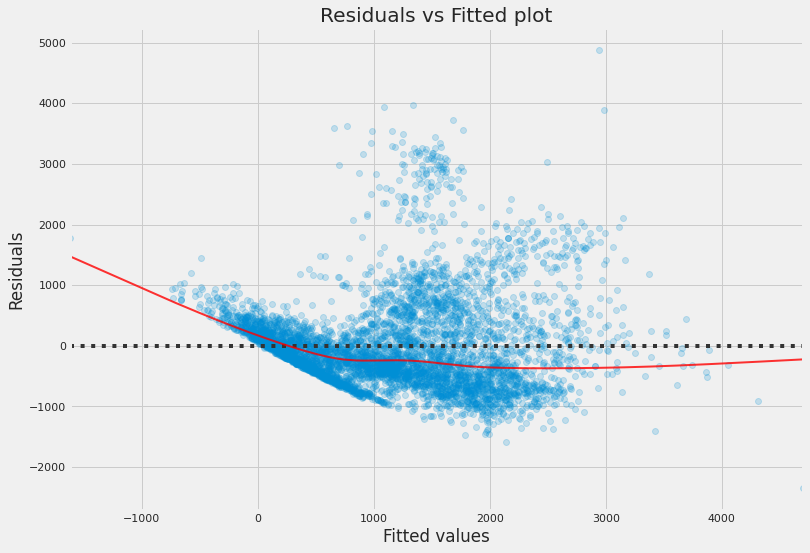

In [59]:
def residuals_vs_fitted_plot(y_pred, y_true, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    sns.residplot(
        x=y_pred,
        y=y_true,
        lowess=True,
        scatter_kws={"alpha": 0.2},
        line_kws={"color": "red", "lw": 2, "alpha": 0.8},
        ax=ax,
    )
    ax.set_title("Residuals vs Fitted plot")
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals");

residuals_vs_fitted_plot(y_pred, y_test)

We observe that there is a trend in the residuals vs fitted plot which signals that we are using the wrong model to model our data. Trends in the residuals vs fitted plot are usually dangerous as they hinder generalisability.

Furthermore, the plot admits a funnel-like shape which indicates a violation of the *constant variance* assumption. Consequently, our estimators $\widehat{\boldsymbol \beta}$ might not be the best linear unbiased estimator (aka BLUE) as the Gauss-Markov theorem does not apply here. As a direct consequence, the prediction we have may not be an unbiased estimator of the cycle hires.

Next, we look at the normal probability plot.

In [60]:
from statsmodels.graphics.gofplots import qqplot

As we see below, the residuals are not normally distributed as its distribution is quite skewed and asymmetric around the expected line.

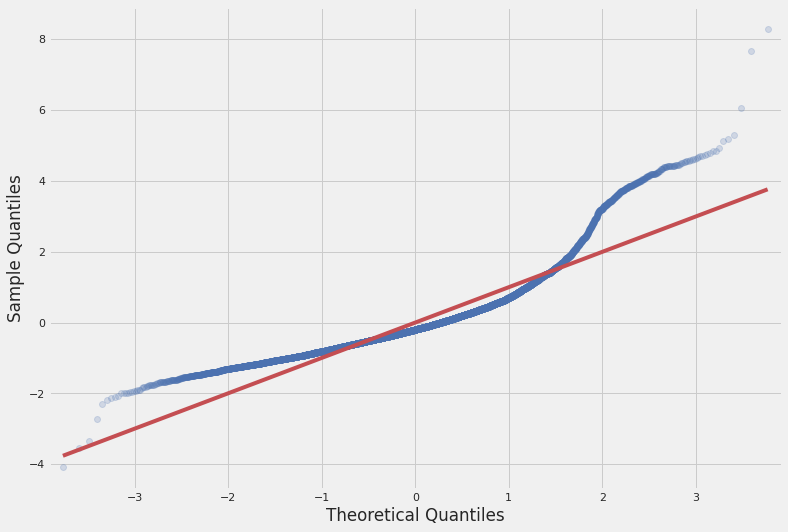

In [61]:
std_residuals = model_sm.get_influence().resid_studentized_internal
qq = qqplot(std_residuals, line="s", alpha=0.2);

## Normalizing using Yeo-Johnson transformation

Looking at the KDE plot of the cycle hires in the training dataset `y_train`, we confirm that indeed the data is skewed and not normally distributed.

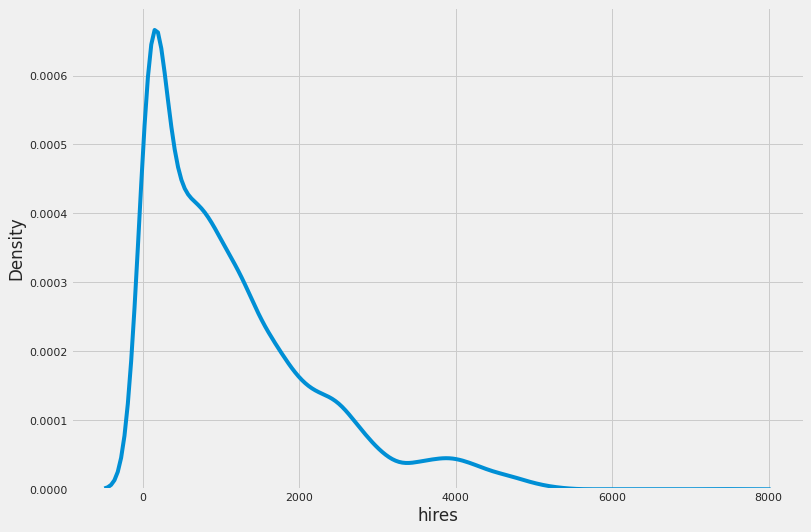

In [62]:
sns.kdeplot(y_train)

To resolve the issues highlighted in the diagnostic plots, we apply a transformation to normalize the data. 

Since the minimum value of the cycle hires is 0 (see cell below), we cannot apply the Box-Cox transformation. Instead, we shall apply the Yeo-Johnson transformation.

In [63]:
# Observe that min = 0, so we can't apply Boxcox
target.min()

0

In [64]:
import scipy.stats as stats

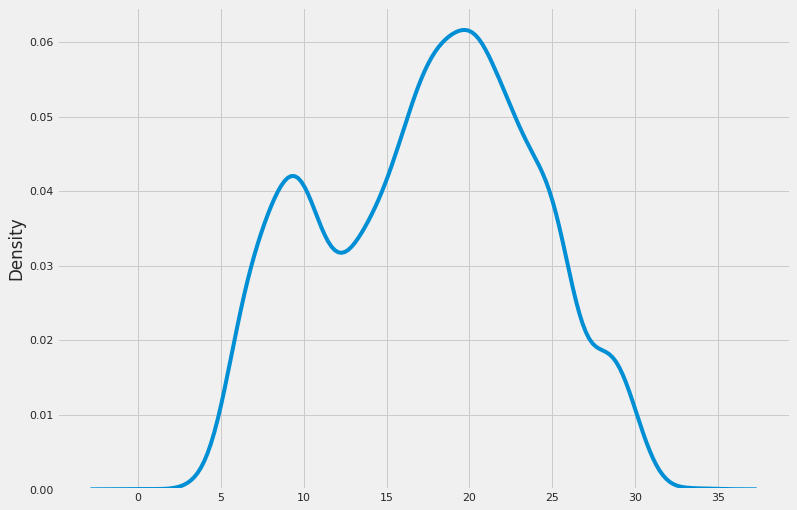

In [65]:
y_train_yj, lambda_yj = stats.yeojohnson(y_train)
sns.kdeplot(y_train_yj)

From the KDE plot above, we see that the resulting dataset after the Yeo-Johnson tranformation admits a bimodal normal distribution. This signals that our data might need nonlinearity after all. However, let's check the performance of a linear model on this transformed dataset.

In [66]:
model_sm = sm.OLS(y_train_yj, X_train_deg3).fit()

y_pred = model_sm.predict(X_test_deg3)
y_test_yj = stats.yeojohnson(y_test, lmbda=lambda_yj)

rmse = mean_squared_error(y_test_yj, y_pred, squared=False)
r2 = r2_score(y_test_yj, y_pred)
adjusted_r2 = adjusted_r2_score(r2, len(y_test_yj), X_test.shape[1])

print(("RMSE linear model on Yeo-Johnson transformed data"
        + f" + cubic power term features: {rmse:.5f}"))
print(f"R^2 score: {r2:.5f}")
print(f"Adjusted R^2 score: {adjusted_r2:.5f}")

RMSE linear model on Yeo-Johnson transformed data + cubic power term features: 3.52509
R^2 score: 0.69328
Adjusted R^2 score: 0.69280


The performance of this model is beyond expectations! The RMSE at **3.53** is a 99% decrease from the benchmark RMSE of 935.49, and a 98.9% decrease from the linear model trained on the features with MA!

The $R^2$ score although not as amazing as the MA model, is an impressive improvement going from 0.271 (benchmark) to **0.693** which is an increase by 155%.

Let's look at the residuals vs fitted plot.

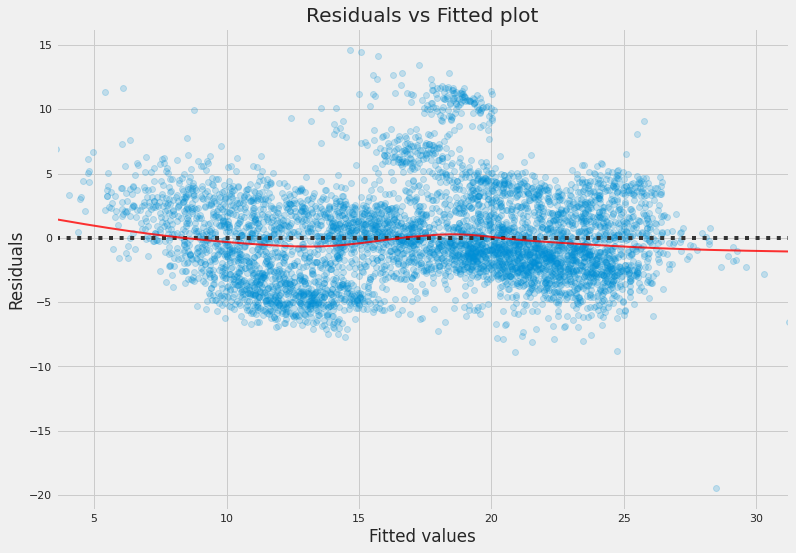

In [67]:
residuals_vs_fitted_plot(y_pred, y_test_yj)

The residuals vs fitted plot looks perfect – there is no trend, no heteroscedasticity problem (i.e. we have constant variance), and no dramatic outliers. One could say that we have the right model already. Finally, we look at the normal Q-Q plot.

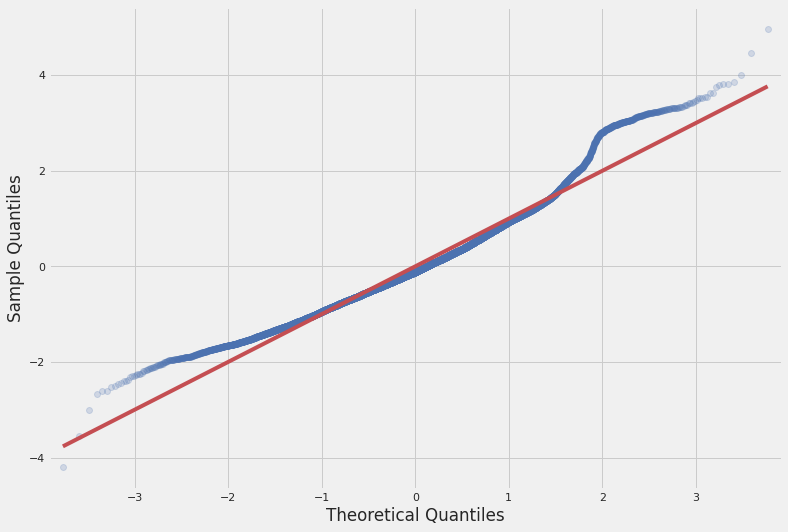

In [68]:
std_residuals = model_sm.get_influence().resid_studentized_internal
qq = qqplot(std_residuals, line="s", alpha=0.2);

Unfortunately, the normal Q-Q plot suggests that the residuals are not normally distributed. In fact, we can see some sort of trend as the extremes of the distribution lies above the expected line and the center of the distribution lies under. Nevertheless, normality of the residuals is not usually a big issue especially if we just want to make predictions.

# Predicting new out-of-sample

Let us now try to use our final model to make predictions.

In [69]:
test_sample = pd.DataFrame(
    dict(hour=13, 
         temp=15, 
         hum=21, 
         wind_speed=17.1, 
         weather_code=3, 
         is_holiday=0, 
         is_weekend=0, 
         season=3),
    index=[0]
)

If we trace back, our final linear model consists of two additional steps:

1. Applying `PolynomialFeatures(degree=3)` to introduce cubic power terms (and interactions) in the data.
2. Applying the Yeo-Johnson transformation to normalise the data.

For prediction to get actual cycle hires, applying step 1 is straightforward as it is the same when we transformed the test dataset. Applying step 2 is different for prediction as Yeo-Johnson transforms the actual number of cycle hires to a different space. Instead, we have to apply the inverse Yeo-Johnson transformation which for our case – when the data is positive and $\lambda \neq 0$ – is given by the function

$$g(y; \lambda) = (y \lambda + 1)^{1/\lambda} - 1.$$

In [70]:
def inverse_yeojohnson(y, lam):
    return (y*lam + 1)**(1/lam) - 1

The complete prediction pipeline is thus given by below.

In [71]:
def pipeline(new_sample):
    new_sample = poly.transform(new_sample) # Auto add constant
    y_pred = model_sm.predict(new_sample)
    return inverse_yeojohnson(y_pred, lambda_yj)

In [72]:
pipeline(test_sample)

array([862.82343204])